In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.model_selection import GridSearchCV

In [3]:
# Loading the Dataset
file_path = "merged_output.csv"     # Path to the dataset
data = pd.read_csv(file_path)

In [4]:
data.head()

,index,connection,timestamps,sizes,directions,file_name
0,1,"('10.184.62.19', 61599, '3.33.252.61', 443, 'T...","1727358570.247294,1727358570.321135,1727358570...","[66, 54, 307, 54, 54]","[0, 1, 0, 1, 0]",google_browsing.pcap
1,2,"('3.33.252.61', 443, '10.184.62.19', 61599, 'T...","1727358570.320960,1727358570.394823,1727358570...","[66, 54, 54]","[0, 0, 1]",google_browsing.pcap
2,3,"('10.184.62.19', 61532, '10.10.1.5', 53, 'UDP')",1727358570.998294,[75],[0],google_browsing.pcap
3,4,"('10.184.62.19', 51497, '10.10.1.5', 53, 'UDP')",1727358570.998542,[75],[0],google_browsing.pcap
4,5,"('10.10.1.5', 53, '10.184.62.19', 61532, 'UDP')",1727358571.000310,[91],[1],google_browsing.pcap


### Preprocessing: convert string array to float

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4987 entries, 0 to 4986
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       4987 non-null   int64 
 1   connection  4987 non-null   object
 2   timestamps  4987 non-null   object
 3   sizes       4987 non-null   object
 4   directions  4987 non-null   object
 5   file_name   4987 non-null   object
dtypes: int64(1), object(5)
memory usage: 233.9+ KB


In [6]:
def get_float(str_array):
    # Remove brackets and split the string by commas
    cleaned_string = str_array.strip("[]")  # Remove [ and ]
    string_list = cleaned_string.split(",")    # Split by commas

    # Convert to a NumPy array of floats
    float_array = np.array(string_list, dtype=float)
    return float_array 

for field in ["sizes", "directions"]:
    print(field)
    data[field] = data[field].apply(lambda x:  get_float(x))
    

sizes
directions


In [7]:
data.head()

,index,connection,timestamps,sizes,directions,file_name
0,1,"('10.184.62.19', 61599, '3.33.252.61', 443, 'T...","1727358570.247294,1727358570.321135,1727358570...","[66.0, 54.0, 307.0, 54.0, 54.0]","[0.0, 1.0, 0.0, 1.0, 0.0]",google_browsing.pcap
1,2,"('3.33.252.61', 443, '10.184.62.19', 61599, 'T...","1727358570.320960,1727358570.394823,1727358570...","[66.0, 54.0, 54.0]","[0.0, 0.0, 1.0]",google_browsing.pcap
2,3,"('10.184.62.19', 61532, '10.10.1.5', 53, 'UDP')",1727358570.998294,[75.0],[0.0],google_browsing.pcap
3,4,"('10.184.62.19', 51497, '10.10.1.5', 53, 'UDP')",1727358570.998542,[75.0],[0.0],google_browsing.pcap
4,5,"('10.10.1.5', 53, '10.184.62.19', 61532, 'UDP')",1727358571.000310,[91.0],[1.0],google_browsing.pcap


### Column description
- index: Index of the row (IGNORE)
- connection: A tuple describing the connection (source IP, source port, destination IP, destination port, protocol).
- timestamps: A list of timestamps indicating when packets for the connection were captured.
- sizes: A list of packet sizes (in bytes) for the connection.
- directions: A list indicating packet directions (1 for source-to-destination, 0 for destination-to-source).
- file_names: The name of the PCAP file from which the data was extracted.

In [8]:
label_col = "label"
data[label_col] = data["file_name"].apply(lambda x: x.replace(".pcap", ""))                # Extract label from the filename

# Dropping Classes with Less Than 5 Instances
class_counts = data[label_col].value_counts()                                               # generate series of class_count
print(class_counts)
data = data[data[label_col].isin(class_counts[class_counts > 5].index)]

le = LabelEncoder()
data["label_encoded"] = le.fit_transform(data["label"])

label
google_browsing           2631
google_drive_upl-dw        530
streaming_spotify          466
google_mail                454
teams_messaging            380
teams_call                 276
streaming_amazon-prime     122
streaming_hotstar           47
streaming_netflix           46
streaming_youtube           35
Name: count, dtype: int64


In [ ]:
data.head(5)

In [ ]:
data.tail(5)

In [9]:
# Hot encoding for labels
print(dict(zip(le.classes_, range(len(le.classes_)))))

{'google_browsing': 0, 'google_drive_upl-dw': 1, 'google_mail': 2, 'streaming_amazon-prime': 3, 'streaming_hotstar': 4, 'streaming_netflix': 5, 'streaming_spotify': 6, 'streaming_youtube': 7, 'teams_call': 8, 'teams_messaging': 9}


In [ ]:
data["label"].value_counts()

In [10]:
data = data.drop(columns=["file_name"])

In [ ]:
print(data["sizes"].head(5))

# Check the data type of each entry in the 'sizes' column
print(data["sizes"].apply(type).value_counts())

direction_example = data.loc[1, "directions"]
print(direction_example)

print(len(direction_example))

In [11]:
def get_avg(x):
    return np.mean(x)

def get_std(x):
    return np.std(x)

def get_sum(x):
    return np.sum(x)

def get_duration(timestamps):
    ts_list = list(map(float, timestamps.split(',')))  # Convert string to list of floats
    return ts_list[-1] - ts_list[0] if len(ts_list) > 1 else 0

def get_total_packets(sizes):
    return len(sizes)

def get_IAT(timestamps):
    ts_list = list(map(float, timestamps.split(',')))  # Convert string to list of floats
    if len(ts_list) > 1:
        return np.diff(ts_list)
    return []           # No IAT for single packet


def get_mean_IAT(timestamps):
    iat = get_IAT(timestamps)
    return np.mean(iat)

def get_std_dev_IAT(timestamps):
    iat = get_IAT(timestamps)
    return np.std(iat)

In [12]:
# Packet-level: avg, std packet sizes
data["avg_pkt_size"] = data["sizes"].apply(get_avg)
data["stddev_pkt_size"] = data["sizes"].apply(get_std)
data["total_size"] = data["sizes"].apply(get_sum)



# Flow duration, total data, total pkts
data["flow_duration"] = data["timestamps"].apply(get_duration)
data["total_packets"] = data["sizes"].apply(get_total_packets)



# Intra-flow: mean and std of inter-arrival time or relative variance
data["mean_IAT"] = data["timestamps"].apply(get_mean_IAT)
data["stddev_IAT"] = data["timestamps"].apply(get_std_dev_IAT)

data.head(4)

c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\manis\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

,index,connection,timestamps,sizes,directions,label,label_encoded,avg_pkt_size,stddev_pkt_size,total_size,flow_duration,total_packets,mean_IAT,stddev_IAT
0,1,"('10.184.62.19', 61599, '3.33.252.61', 443, 'T...","1727358570.247294,1727358570.321135,1727358570...","[66.0, 54.0, 307.0, 54.0, 54.0]","[0.0, 1.0, 0.0, 1.0, 0.0]",google_browsing,0,107.0,100.107942,535.0,0.147689,5,0.036922,0.036433
1,2,"('3.33.252.61', 443, '10.184.62.19', 61599, 'T...","1727358570.320960,1727358570.394823,1727358570...","[66.0, 54.0, 54.0]","[0.0, 0.0, 1.0]",google_browsing,0,58.0,5.656854,174.0,0.146736,3,0.073368,0.000495
2,3,"('10.184.62.19', 61532, '10.10.1.5', 53, 'UDP')",1727358570.998294,[75.0],[0.0],google_browsing,0,75.0,0.000000,75.0,0.000000,1,NaN,NaN
3,4,"('10.184.62.19', 51497, '10.10.1.5', 53, 'UDP')",1727358570.998542,[75.0],[0.0],google_browsing,0,75.0,0.000000,75.0,0.000000,1,NaN,NaN


In [13]:
feature_cols = ["avg_pkt_size", "stddev_pkt_size", "total_size", "flow_duration", "mean_IAT", "stddev_IAT"]  # Feature selection

# Drop values with no data
data_tmp = data.dropna()
features = data_tmp[feature_cols]
labels = data_tmp["label_encoded"]
print(data_tmp.shape)

(3576, 14)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Simple Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

                        precision    recall  f1-score   support

       google_browsing       0.84      0.93      0.88       722
   google_drive_upl-dw       0.48      0.51      0.49        96
           google_mail       0.51      0.31      0.39        83
streaming_amazon-prime       0.81      0.70      0.75        30
     streaming_hotstar       0.18      0.29      0.22         7
     streaming_netflix       0.40      0.20      0.27        10
     streaming_spotify       0.63      0.45      0.53        53
     streaming_youtube       0.00      0.00      0.00         5
            teams_call       0.73      0.34      0.47        32
       teams_messaging       0.41      0.26      0.32        35

              accuracy                           0.76      1073
             macro avg       0.50      0.40      0.43      1073
          weighted avg       0.74      0.76      0.74      1073



In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initalizing the Random Forest Classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Performing Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Classification report
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=30,
    learning_rate=0.05,
    scale_pos_weight=1.5,  # Helps with imbalance
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='accuracy')

print("Stratified K-Fold Accuracy:", scores.mean())

In [ ]:
# Confusion Matrix plot for RF
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

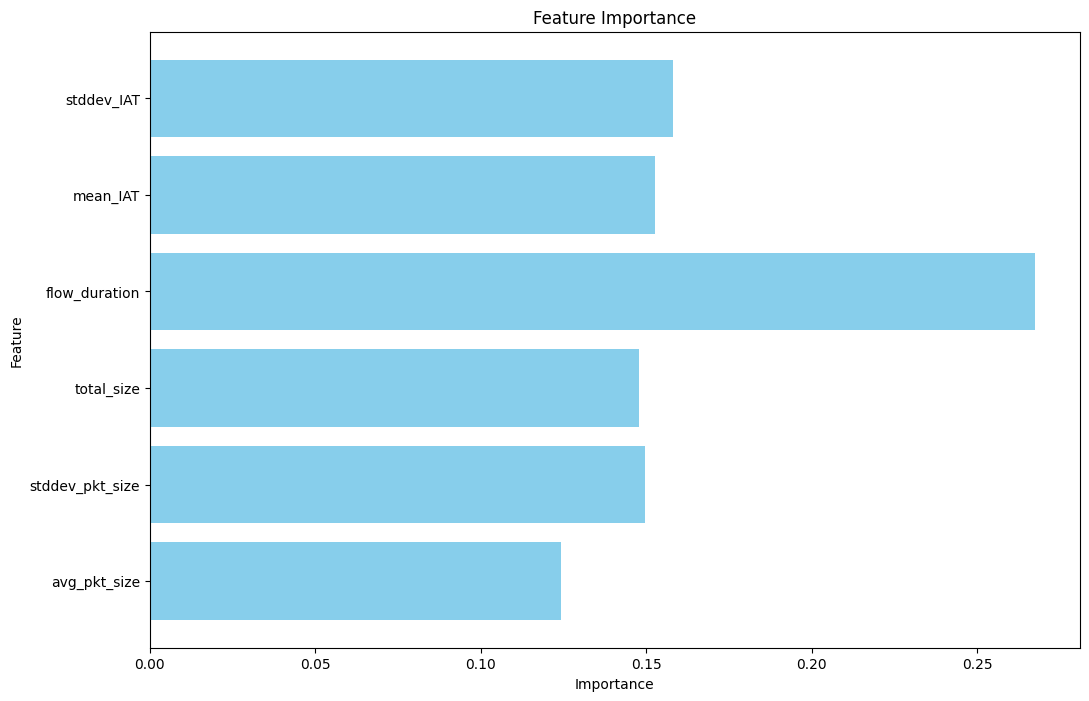

In [16]:
# Plot for Feature Importance
importances = rf.feature_importances_
feature_names = features.columns

plt.figure(figsize=(12, 8))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()